In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# -----------------------------segmenting
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

#------------------------------knowledge
import json

# -----------------------------Intrested category prediction
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


In [36]:
df = pd.read_csv("../dataset/shopping_trends.csv")
print(df.info())

<class 'pandas.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer ID               3900 non-null   int64  
 1   Age                       3900 non-null   int64  
 2   Gender                    3900 non-null   str    
 3   Item Purchased            3900 non-null   str    
 4   Category                  3900 non-null   str    
 5   Purchase Amount (USD)     3900 non-null   int64  
 6   Location                  3900 non-null   str    
 7   Size                      3900 non-null   str    
 8   Color                     3900 non-null   str    
 9   Season                    3900 non-null   str    
 10  Review Rating             3900 non-null   float64
 11  Subscription Status       3900 non-null   str    
 12  Payment Method            3900 non-null   str    
 13  Shipping Type             3900 non-null   str    
 14  Discount Applied   

In [37]:
df = df.drop_duplicates()

yes_no_cols = [
    "Subscription Status",
    "Discount Applied",
    "Promo Code Used"
]

for col in yes_no_cols:
    df[col] = df[col].map({"Yes": 1, "No": 0})

df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [38]:
frequency_map = {
    "Weekly": 5,
    "Bi-Weekly": 4,
    "Fortnightly": 4,
    "Monthly": 3,
    "Quarterly": 2,
    "Every 3 Months": 2,
    "Annually": 1
}

df["Frequency Score"] = df["Frequency of Purchases"].map(frequency_map)

In [39]:
features = [
    "Age",
    "Purchase Amount (USD)",
    "Previous Purchases",
    "Review Rating",
    "Frequency Score",
    "Subscription Status",
    "Discount Applied",
    "Promo Code Used",
    "Category",
    "Season",
    "Payment Method",
    "Shipping Type",
    "Gender"
]

X = df[features]


for i in df.columns:
    if i not in X.columns:
        print(i," ")

Customer ID  
Item Purchased  
Location  
Size  
Color  
Preferred Payment Method  
Frequency of Purchases  


In [40]:
numeric_features = [
    "Age",
    "Purchase Amount (USD)",
    "Previous Purchases",
    "Review Rating",
    "Frequency Score"
]

binary_features = [
    "Subscription Status",
    "Discount Applied",
    "Promo Code Used"
]

categorical_features = [
    "Category",
    "Season",
    "Payment Method",
    "Shipping Type",
    "Gender"
]

In [41]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("bin", "passthrough", binary_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

In [42]:
pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor)
])

In [43]:
X_processed = pipeline.fit_transform(X)

print("Processed Shape:", X_processed.shape)

Processed Shape: (3900, 30)


In [44]:
joblib.dump(pipeline, "../final_models/preprocessing_pipeline.pkl")

['../final_models/preprocessing_pipeline.pkl']

##SEGMENTING CUSTOMERS

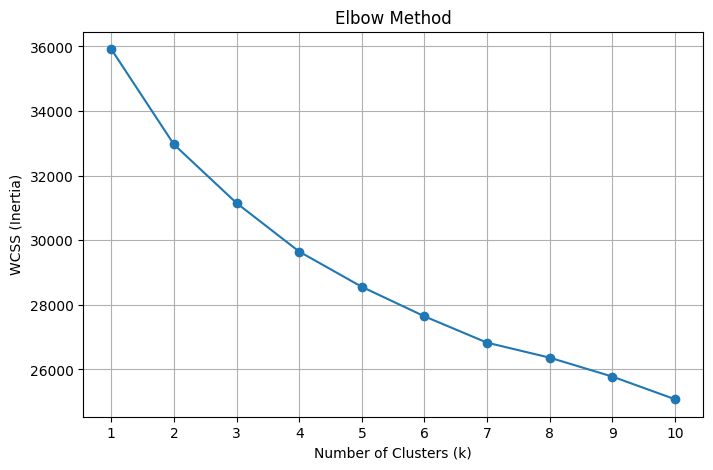

In [45]:
wcss = []

K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_processed)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, wcss, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Inertia)")
plt.xticks(K_range)
plt.grid(True)
plt.show()

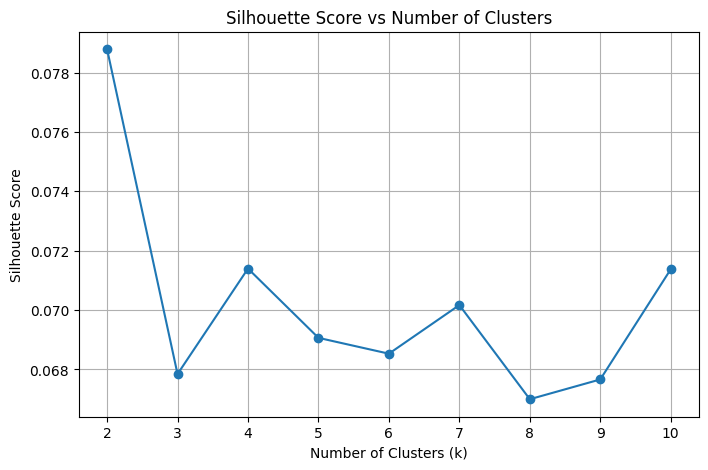

In [46]:
silhouette_scores = []

K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_processed)
    score = silhouette_score(X_processed, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8,5))
plt.plot(K_range, silhouette_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.xticks(K_range)
plt.grid(True)
plt.show()

In [47]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_processed)

In [48]:
df["Segment"] = clusters

Segment summary

In [49]:
segment_summary = df.groupby("Segment").agg({
    "Age": "mean",
    "Purchase Amount (USD)": "mean",
    "Previous Purchases": "mean",
    "Review Rating": "mean",
    "Frequency Score": "mean"
})

print(segment_summary)

               Age  Purchase Amount (USD)  Previous Purchases  Review Rating  \
Segment                                                                        
0        56.044103              81.349744           27.121026       4.017744   
1        32.531522              69.930435           21.145652       3.131304   
2        31.709072              51.914494           25.629823       4.411262   
3        54.384321              37.899618           27.146272       3.438145   

         Frequency Score  
Segment                   
0               2.827692  
1               3.197826  
2               3.069864  
3               2.804015  


Category Distribution per Segment

In [50]:
category_dist = pd.crosstab(df["Segment"], df["Category"])
print(category_dist)

Category  Accessories  Clothing  Footwear  Outerwear
Segment                                             
0                 291       449       161         74
1                 287       429       132         72
2                 331       412       141         75
3                 331       447       165        103


Discount Usage per Segment

In [51]:
discount_analysis = df.groupby("Segment")["Promo Code Used"].mean()
print(discount_analysis)

Segment
0    0.405128
1    0.418478
2    0.425443
3    0.467495
Name: Promo Code Used, dtype: float64


In [52]:
segment_labels = {
    0: "Premium Urgent Buyers",
    1: "Loyal Frequent Buyers",
    2: "Occasional Buyers",
    3: "Discount-Driven Shoppers"
}

df["Segment Label"] = df["Segment"].map(segment_labels)

In [53]:
joblib.dump(kmeans, "../final_models/kmeans_model.pkl")

['../final_models/kmeans_model.pkl']

----testuser----

In [54]:
new_user = pd.DataFrame([{
    "Age": 28,
    "Purchase Amount (USD)": 60,
    "Previous Purchases": 15,
    "Review Rating": 4.5,
    "Frequency Score": 4,
    "Subscription Status": 1,
    "Discount Applied": 1,
    "Promo Code Used": 1,
    "Category": "Clothing",
    "Season": "Winter",
    "Payment Method": "Credit Card",
    "Shipping Type": "Express",
    "Gender": "Male"
}])

In [55]:
pipeline = joblib.load("../final_models/preprocessing_pipeline.pkl")
kmeans = joblib.load("../final_models/kmeans_model.pkl")

new_user_processed = pipeline.transform(new_user)
new_segment = kmeans.predict(new_user_processed)

print("User belongs to segment:", segment_labels[new_segment[0]])

User belongs to segment: Occasional Buyers


Affinity Analysis

In [56]:
category_affinity = pd.crosstab(df["Segment Label"], df["Category"], normalize="index") * 100
print(category_affinity.round(2))

Category                  Accessories  Clothing  Footwear  Outerwear
Segment Label                                                       
Discount-Driven Shoppers        31.64     42.73     15.77       9.85
Loyal Frequent Buyers           31.20     46.63     14.35       7.83
Occasional Buyers               34.52     42.96     14.70       7.82
Premium Urgent Buyers           29.85     46.05     16.51       7.59


In [57]:
season_affinity = pd.crosstab(df["Segment Label"], df["Season"], normalize="index") * 100
print(season_affinity.round(2))

Season                     Fall  Spring  Summer  Winter
Segment Label                                          
Discount-Driven Shoppers  24.00   27.34   25.33   23.33
Loyal Frequent Buyers     28.15   22.07   21.41   28.37
Occasional Buyers         22.31   26.80   26.90   23.98
Premium Urgent Buyers     25.74   25.95   24.10   24.21


In [58]:
payment_affinity = pd.crosstab(df["Segment Label"], df["Payment Method"], normalize="index") * 100
print(payment_affinity.round(2))

Payment Method            Bank Transfer   Cash  Credit Card  Debit Card  \
Segment Label                                                             
Discount-Driven Shoppers          16.73  18.64        17.21       16.06   
Loyal Frequent Buyers             13.48  17.07        19.24       18.70   
Occasional Buyers                 18.14  14.08        16.89       16.06   
Premium Urgent Buyers             16.31  16.51        18.15       14.26   

Payment Method            PayPal  Venmo  
Segment Label                            
Discount-Driven Shoppers   15.97  15.39  
Loyal Frequent Buyers      15.98  15.54  
Occasional Buyers          18.77  16.06  
Premium Urgent Buyers      14.77  20.00  


In [59]:
shipping_affinity = pd.crosstab(df["Segment Label"], df["Shipping Type"], normalize="index") * 100
print(shipping_affinity.round(2))

Shipping Type             2-Day Shipping  Express  Free Shipping  \
Segment Label                                                      
Discount-Driven Shoppers           14.15    16.54          16.35   
Loyal Frequent Buyers              18.04    15.11          18.70   
Occasional Buyers                  16.27    16.16          16.79   
Premium Urgent Buyers              16.10    18.36          17.54   

Shipping Type             Next Day Air  Standard  Store Pickup  
Segment Label                                                   
Discount-Driven Shoppers         17.50     18.83         16.63  
Loyal Frequent Buyers            18.04     13.15         16.96  
Occasional Buyers                15.43     17.41         17.94  
Premium Urgent Buyers            15.49     17.33         15.18  


In [60]:
discount_behavior = df.groupby("Segment Label")[["Discount Applied", "Promo Code Used"]].mean() * 100
print(discount_behavior.round(2))

                          Discount Applied  Promo Code Used
Segment Label                                              
Discount-Driven Shoppers             46.75            46.75
Loyal Frequent Buyers                41.85            41.85
Occasional Buyers                    42.54            42.54
Premium Urgent Buyers                40.51            40.51


In [61]:
satisfaction_profile = df.groupby("Segment Label")["Review Rating"].mean()
print(satisfaction_profile.round(2))

Segment Label
Discount-Driven Shoppers    3.44
Loyal Frequent Buyers       3.13
Occasional Buyers           4.41
Premium Urgent Buyers       4.02
Name: Review Rating, dtype: float64


In [62]:
for segment in df["Segment Label"].unique():
    print("\n==============================")
    print("Segment:", segment)
    print("Avg Spend:", df[df["Segment Label"]==segment]["Purchase Amount (USD)"].mean())
    print("Top Category:", df[df["Segment Label"]==segment]["Category"].mode()[0])
    print("Top Shipping:", df[df["Segment Label"]==segment]["Shipping Type"].mode()[0])


Segment: Discount-Driven Shoppers
Avg Spend: 37.89961759082218
Top Category: Clothing
Top Shipping: Standard

Segment: Loyal Frequent Buyers
Avg Spend: 69.9304347826087
Top Category: Clothing
Top Shipping: Free Shipping

Segment: Premium Urgent Buyers
Avg Spend: 81.3497435897436
Top Category: Clothing
Top Shipping: Express

Segment: Occasional Buyers
Avg Spend: 51.91449426485923
Top Category: Clothing
Top Shipping: Store Pickup


In [63]:
segment_knowledge = {}

for segment in df["Segment Label"].unique():
    segment_data = df[df["Segment Label"] == segment]

    segment_knowledge[segment] = {
        "avg_spend": segment_data["Purchase Amount (USD)"].mean(),
        "avg_frequency": segment_data["Frequency Score"].mean(),
        "avg_rating": segment_data["Review Rating"].mean(),
        "top_category": segment_data["Category"].mode()[0],
        "top_season": segment_data["Season"].mode()[0],
        "top_payment_method": segment_data["Payment Method"].mode()[0],
        "top_shipping_type": segment_data["Shipping Type"].mode()[0],
        "discount_usage_percent": segment_data["Promo Code Used"].mean() * 100
    }

segment_knowledge

{'Discount-Driven Shoppers': {'avg_spend': np.float64(37.89961759082218),
  'avg_frequency': np.float64(2.8040152963671128),
  'avg_rating': np.float64(3.438145315487572),
  'top_category': 'Clothing',
  'top_season': 'Spring',
  'top_payment_method': 'Cash',
  'top_shipping_type': 'Standard',
  'discount_usage_percent': np.float64(46.749521988527725)},
 'Loyal Frequent Buyers': {'avg_spend': np.float64(69.9304347826087),
  'avg_frequency': np.float64(3.1978260869565216),
  'avg_rating': np.float64(3.131304347826087),
  'top_category': 'Clothing',
  'top_season': 'Winter',
  'top_payment_method': 'Credit Card',
  'top_shipping_type': 'Free Shipping',
  'discount_usage_percent': np.float64(41.84782608695652)},
 'Premium Urgent Buyers': {'avg_spend': np.float64(81.3497435897436),
  'avg_frequency': np.float64(2.8276923076923075),
  'avg_rating': np.float64(4.01774358974359),
  'top_category': 'Clothing',
  'top_season': 'Spring',
  'top_payment_method': 'Venmo',
  'top_shipping_type': 'E

In [64]:
with open("../final_models/segment_knowledge.json", "w") as f:
    json.dump(segment_knowledge, f)

In [65]:
df.columns

Index(['Customer ID', 'Age', 'Gender', 'Item Purchased', 'Category',
       'Purchase Amount (USD)', 'Location', 'Size', 'Color', 'Season',
       'Review Rating', 'Subscription Status', 'Payment Method',
       'Shipping Type', 'Discount Applied', 'Promo Code Used',
       'Previous Purchases', 'Preferred Payment Method',
       'Frequency of Purchases', 'Frequency Score', 'Segment',
       'Segment Label'],
      dtype='str')

In [66]:
df.to_csv("../dataset/preprocessed.csv", index = False)

In [67]:
options = {
    "categories": sorted(df["Category"].dropna().unique().tolist()),
    "payment_methods": sorted(df["Payment Method"].dropna().unique().tolist()),
    "shipping_types": sorted(df["Shipping Type"].dropna().unique().tolist()),
    "seasons": sorted(df["Season"].dropna().unique().tolist()),
    "genders": sorted(df["Gender"].dropna().unique().tolist())
}

with open("../final_models/allowed_options.json", "w") as f:
    json.dump(options, f, indent=4)

print("Extracted Options:")
print(json.dumps(options, indent=4))

Extracted Options:
{
    "categories": [
        "Accessories",
        "Clothing",
        "Footwear",
        "Outerwear"
    ],
    "payment_methods": [
        "Bank Transfer",
        "Cash",
        "Credit Card",
        "Debit Card",
        "PayPal",
        "Venmo"
    ],
    "shipping_types": [
        "2-Day Shipping",
        "Express",
        "Free Shipping",
        "Next Day Air",
        "Standard",
        "Store Pickup"
    ],
    "seasons": [
        "Fall",
        "Spring",
        "Summer",
        "Winter"
    ],
    "genders": [
        "Female",
        "Male"
    ]
}
